# Case Engenharia de Dados Elo7


|Elo7
|:-----------------------------------------------|
|**Objetivo:** Processar e armazenar os dados de atrasos em vôos de diversos aeroportos de forma que possamos criar análises utilizando alguma ferramente de BI.
|**Desenvolvedora :** Nathalia oliveira
|**Data:** Junho/2022|
|**Tempo médio de execução nos testes:** 1 min

|SUMÁRIO|
|:------------------------------------------------|
|[**1. Objetivo**](#um)
|[**2. Dataset**](#dois)
|[**3. Configurações Gerais**](#tres)
|[**4. Download e tratamento do Dataset**](#quatro)
|[**5. Questões**](#cinco)


<div id='um' />

# Objetivo

Processar e armazenar os dados de **atrasos** em vôos de diversos aeroportos de forma que possamos criar análises utilizando alguma ferramente de BI. 
Nesse projeto, desenvolvido na plataforma google colab, a idéia é utilizar Spark para processamento e estruturação dos dados para disponibilização das bases que respondam às questóes abaixo:

##### Base utilizada:  <a href= "https://corgis-edu.github.io/corgis/datasets/json/airlines/airlines.json">Airlines</a>

Perguntas a serem respondidas:

*   Qual a curva da quantidade de atrasos causados pela segurança dos aeroportos (Gráfico de linhas, por exemplo)
*   Qual aeroporto teve a pior média de tempo de atrasos no último ano (do dataset)?
*  Dos motivos que causam atrasos, qual é o que mais causou tempo de atraso?
*  Comparando ano contra ano, 2015 foi melhor ou pior que 2014 em termos de número de atrasos?

















<div id='tres' />

# Dataset

Pesquisando na <a href= "https://corgis-edu.github.io/corgis/python/airlines/">página</a> de disponibilização da base, não foi possível acessar um dicionário de dados. Porém, é esclarescido que a base consiste em uma agregação de dados dos principais aeroportos do país(EUA), com uma visão mensal. Os dados são referentes ao período de 2003(conforme informado no endereço, até janeiro de 2016(conforme verificado diretamente na base através desse script)

<div id='tres' />

# Configurações gerais

In [ ]:
# instalando as dependências necessárias
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q typing

     |████████████████████████████████| 78 kB 3.9 MB/s 


In [ ]:
# importando bibliotecas

import os
# configurando as variáveis de ambiente
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

import pyspark
import json

from typing import Dict, Tuple
from pyspark.sql.functions import col, lit
from pyspark.sql.types import StructType


In [65]:
# iniciando uma sessão local

from pyspark.sql import SparkSession
sc = SparkSession.builder.master('local[*]').getOrCreate()

<div id='tres' />

# Download e tratamento do Dataset

In [116]:
# download do http para arquivo local
!wget --quiet --show-progress https://corgis-edu.github.io/corgis/datasets/json/airlines/airlines.json

airlines.json.1     100%[===================>]   4.73M  --.-KB/s    in 0.05s   


In [117]:
# Cria Dataframe a partir do Json 
df_flights = sc.read.option("multiline",True).json("./airlines.json")

In [118]:
# verificando estrutura
df_flights.printSchema()

root
 |-- Airport: struct (nullable = true)
 |    |-- Code: string (nullable = true)
 |    |-- Name: string (nullable = true)
 |-- Statistics: struct (nullable = true)
 |    |-- # of Delays: struct (nullable = true)
 |    |    |-- Carrier: long (nullable = true)
 |    |    |-- Late Aircraft: long (nullable = true)
 |    |    |-- National Aviation System: long (nullable = true)
 |    |    |-- Security: long (nullable = true)
 |    |    |-- Weather: long (nullable = true)
 |    |-- Carriers: struct (nullable = true)
 |    |    |-- Names: string (nullable = true)
 |    |    |-- Total: long (nullable = true)
 |    |-- Flights: struct (nullable = true)
 |    |    |-- Cancelled: long (nullable = true)
 |    |    |-- Delayed: long (nullable = true)
 |    |    |-- Diverted: long (nullable = true)
 |    |    |-- On Time: long (nullable = true)
 |    |    |-- Total: long (nullable = true)
 |    |-- Minutes Delayed: struct (nullable = true)
 |    |    |-- Carrier: long (nullable = true)
 |    |  

In [119]:
df_flights.show(2)

+--------------------+--------------------+--------------------+
|             Airport|          Statistics|                Time|
+--------------------+--------------------+--------------------+
|[ATL, Atlanta, GA...|[[1009, 1275, 321...|[2003/06, 6, June...|
|[BOS, Boston, MA:...|[[374, 495, 685, ...|[2003/06, 6, June...|
+--------------------+--------------------+--------------------+
only showing top 2 rows



In [120]:
# O Dataframe foi criado no esquema strtuct. Vamos  usar a função abaixo para retornar as colunas "niveladas"
def flatten_struct(schema, prefix=""):
    result = []
    for elem in schema:
        if isinstance(elem.dataType, StructType):
            result += flatten_struct(elem.dataType, prefix + elem.name + ".")
        else:
            result.append(col(prefix + elem.name).alias(prefix + elem.name))
    return result


In [121]:
# Aplicando função
df_flights_flattened = df_flights.select(flatten_struct(df_flights.schema))

In [122]:
df_flights_flattened.show(1)

+------------+--------------------+------------------------------+------------------------------------+-----------------------------------------------+-------------------------------+------------------------------+-------------------------+-------------------------+----------------------------+--------------------------+---------------------------+--------------------------+------------------------+----------------------------------+----------------------------------------+---------------------------------------------------+-----------------------------------+--------------------------------+----------------------------------+----------+----------+---------------+---------+
|Airport.Code|        Airport.Name|Statistics.# of Delays.Carrier|Statistics.# of Delays.Late Aircraft|Statistics.# of Delays.National Aviation System|Statistics.# of Delays.Security|Statistics.# of Delays.Weather|Statistics.Carriers.Names|Statistics.Carriers.Total|Statistics.Flights.Cancelled|Statistics.Flights.Del

In [123]:
df_flights_flattened.printSchema()

root
 |-- Airport.Code: string (nullable = true)
 |-- Airport.Name: string (nullable = true)
 |-- Statistics.# of Delays.Carrier: long (nullable = true)
 |-- Statistics.# of Delays.Late Aircraft: long (nullable = true)
 |-- Statistics.# of Delays.National Aviation System: long (nullable = true)
 |-- Statistics.# of Delays.Security: long (nullable = true)
 |-- Statistics.# of Delays.Weather: long (nullable = true)
 |-- Statistics.Carriers.Names: string (nullable = true)
 |-- Statistics.Carriers.Total: long (nullable = true)
 |-- Statistics.Flights.Cancelled: long (nullable = true)
 |-- Statistics.Flights.Delayed: long (nullable = true)
 |-- Statistics.Flights.Diverted: long (nullable = true)
 |-- Statistics.Flights.On Time: long (nullable = true)
 |-- Statistics.Flights.Total: long (nullable = true)
 |-- Statistics.Minutes Delayed.Carrier: long (nullable = true)
 |-- Statistics.Minutes Delayed.Late Aircraft: long (nullable = true)
 |-- Statistics.Minutes Delayed.National Aviation System

In [124]:
# Criando "TempView" para manipulação utilizando Spark SQL
df_flights_flattened.createOrReplaceTempView("Flights")

In [125]:
data_flights = sc.sql('''
  SELECT
    `Airport.Code`,
    `Airport.Name`,
    `Statistics.# of Delays.Carrier`,
    `Statistics.# of Delays.Late Aircraft`,
    `Statistics.# of Delays.National Aviation System`,
    `Statistics.# of Delays.Security`,
    `Statistics.# of Delays.Weather`, 
    `Statistics.Carriers.Names`, 
    `Statistics.Carriers.Total`, 
    `Statistics.Flights.Cancelled`,
    `Statistics.Flights.Delayed`, 
    `Statistics.Flights.Diverted`, 
    `Statistics.Flights.On Time`, 
    `Statistics.Flights.Total`,
    `Statistics.Minutes Delayed.Carrier`, 
    `Statistics.Minutes Delayed.Late Aircraft`, 
    `Statistics.Minutes Delayed.National Aviation System`, 
    `Statistics.Minutes Delayed.Security`, 
    `Statistics.Minutes Delayed.Total`, 
    `Statistics.Minutes Delayed.Weather`,
    `Time.Label`, 
    `Time.Month`, 
    `Time.Month Name`, 
    `Time.Year`
FROM
  Flights
LIMIT 10
''')

data_flights.show()

+------------+--------------------+------------------------------+------------------------------------+-----------------------------------------------+-------------------------------+------------------------------+-------------------------+-------------------------+----------------------------+--------------------------+---------------------------+--------------------------+------------------------+----------------------------------+----------------------------------------+---------------------------------------------------+-----------------------------------+--------------------------------+----------------------------------+----------+----------+---------------+---------+
|Airport.Code|        Airport.Name|Statistics.# of Delays.Carrier|Statistics.# of Delays.Late Aircraft|Statistics.# of Delays.National Aviation System|Statistics.# of Delays.Security|Statistics.# of Delays.Weather|Statistics.Carriers.Names|Statistics.Carriers.Total|Statistics.Flights.Cancelled|Statistics.Flights.Del

In [126]:
# VERIFICANDO PADRÃO ANO_MES

sc.sql('''
SELECT DISTINCT 
  char_length( `Time.Label`) 
FROM
  FLIGHTS
ORDER BY
   1
''').show()

+------------------+
|length(Time.Label)|
+------------------+
|                 7|
+------------------+



In [127]:
# VERIFICANDO POSSÍVEIS DUPLICIDADES DE REGISTROS X AEROPORTOS

sc.sql('''
SELECT 
  `Airport.Code`,
  DATE_FORMAT((to_date((`Time.Label`),"yyyy/MM") ),'yyyy-MM') AS ANO_MES,
  COUNT(`Airport.Code`) AS QTD
FROM 
  Flights
GROUP BY
 `Airport.Code`,
 DATE_FORMAT((to_date((`Time.Label`),"yyyy/MM") ),'yyyy-MM')
HAVING
  COUNT(`Airport.Code`) > 1
''').show()


+------------+-------+---+
|Airport.Code|ANO_MES|QTD|
+------------+-------+---+
+------------+-------+---+



In [128]:
# VERIFICANDO DATA MAIS RECENTE 

sc.sql('''
SELECT 
  MAX(DATE_FORMAT((to_date((`Time.Label`),"yyyy/MM") ),'yyyy-MM')) AS ANO_MES
FROM 
  Flights
''').show()



+-------+
|ANO_MES|
+-------+
|2016-01|
+-------+



In [129]:
%time
# Reestruturando a base para facilitar a manipulação
# Seguindo a linha de utilizar uma tabela fato para armazenar os dados de atraso


data_flights_delay_reasons = sc.sql('''

   WITH DATA_FLIGHTS_UNPIVOT_OCURRENCES as (  SELECT
                        `Airport.Code` AS Airport_Code,
                        `Airport.Name` AS Airport_Name, 
                        `Time.Label` AS Time_Label,
                         STACK(5,

                              '`Statistics.# of Delays.Carrier`',`Statistics.# of Delays.Carrier`,
                              '`Statistics.# of Delays.Late Aircraft`',`Statistics.# of Delays.Late Aircraft`,
                              '`Statistics.# of Delays.National Aviation System`',`Statistics.# of Delays.National Aviation System`,
                              '`Statistics.# of Delays.Security`',`Statistics.# of Delays.Security`,
                              '`Statistics.# of Delays.Weather`',`Statistics.# of Delays.Weather`) 
                              
                        AS  (Delayed_Reason, TOTAL_OCCURRENCES)

                      FROM 
                        Flights
                        ),
	    DATA_FLIGHTS_UNPIVOT_MINUTES as (  SELECT
                        `Airport.Code` AS Airport_Code,
                        `Airport.Name` AS Airport_Name, 
                        `Time.Label` AS Time_Label,
                        STACK(5,
                              '`Statistics.Minutes Delayed.Weather`',`Statistics.Minutes Delayed.Weather`,
                              '`Statistics.Minutes Delayed.Security`',`Statistics.Minutes Delayed.Security`,
                              '`Statistics.Minutes Delayed.National Aviation System`',`Statistics.Minutes Delayed.National Aviation System`,
                              '`Statistics.Minutes Delayed.Late Aircraft`',`Statistics.Minutes Delayed.Late Aircraft`,
                              '`Statistics.Minutes Delayed.Carrier`',`Statistics.Minutes Delayed.Carrier`) 
                              
                        AS  (Delayed_Reason, TOTAL_MINUTES)

                      FROM 
                        Flights
                        )					
						
    SELECT
      FO.Airport_Code,
      FO.Airport_Name,
      FO.Time_Label,
      REPLACE((REPLACE(FO.Delayed_Reason,'`Statistics.# of Delays.','')),'`') AS Delayed_Reason,
      FO.Total_Occurrences,
      FM.Total_Minutes
    FROM
      DATA_FLIGHTS_UNPIVOT_OCURRENCES FO LEFT JOIN DATA_FLIGHTS_UNPIVOT_MINUTES FM
	ON 
		    FO.Airport_Code = FM.Airport_Code
		AND FO.Time_Label   = FM.Time_Label
    AND REPLACE((REPLACE(FO.Delayed_Reason,'`Statistics.# of Delays.','')),'`') =  REPLACE((REPLACE(FM.Delayed_Reason,'`Statistics.Minutes Delayed.','')),'`')
                        ''') 


data_flights_delay_reasons.show(5,truncate = False)

data_flights_delay_reasons.createOrReplaceTempView("Flights_Delayed")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.4 µs
+------------+-----------------------------------------------------+----------+------------------------+-----------------+-------------+
|Airport_Code|Airport_Name                                         |Time_Label|Delayed_Reason          |Total_Occurrences|Total_Minutes|
+------------+-----------------------------------------------------+----------+------------------------+-----------------+-------------+
|ATL         |Atlanta, GA: Hartsfield-Jackson Atlanta International|2003/06   |Carrier                 |1009             |61606        |
|ATL         |Atlanta, GA: Hartsfield-Jackson Atlanta International|2003/06   |Late Aircraft           |1275             |68335        |
|ATL         |Atlanta, GA: Hartsfield-Jackson Atlanta International|2003/06   |National Aviation System|3217             |118831       |
|ATL         |Atlanta, GA: Hartsfield-Jackson Atlanta International|2003/06   |Security                |17        

<div id='cinco' />

# Questões

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


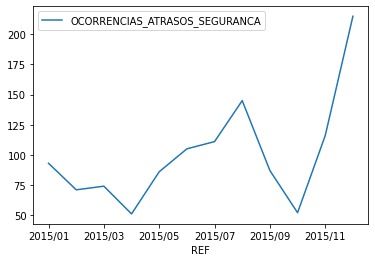

In [130]:
%time
# Qual a curva da quantidade de atrasos causados pela segurança dos aeroportos?
# Considerando O ano completo mais recente(2015) para análise:

security_delay = sc.sql('''

SELECT 
  Time_Label AS REF,
  SUM(Total_Occurrences) AS OCORRENCIAS_ATRASOS_SEGURANCA
FROM
  Flights_Delayed
WHERE
  Delayed_Reason = 'Security'                
  AND left(Time_Label,4) = '2015'
GROUP BY 
  Time_Label
ORDER BY
  1 ASC
 ''') 

security_delay_chart = (
    security_delay.select(
        "REF",
        "OCORRENCIAS_ATRASOS_SEGURANCA"
                            )
    .orderBy("REF")
    .toPandas()
)

security_delay_chart.plot.line(x="REF", y={ "OCORRENCIAS_ATRASOS_SEGURANCA"})


In [131]:
# Qual aeroporto teve a pior média de tempo de atrasos no último ano (do dataset)?
# Nessa pergunta, vou partir do ultimo(maior) ano disponível no dataset (e não do último ano disponível por aeroporto), como parametro
# Nesse cenário o último ano disponível é 2016, porém contempla apenas 1 mês. Para melhor verificação, seria necessário entender com a área de negócio, o critério a ser considerado. Ex.: 
# Últimos 12 Meses, último ano fechado disponível?..


max_year = sc.sql('''
                    SELECT 
                      MAX(`Time.Label`)
                    FROM
                      Flights
                 ''' ).first()[0]

In [132]:
# Qual aeroporto teve a pior média de tempo de atrasos no último ano (do dataset)?
# Melhoria: para processo dinâmico, definir parâmetro para ano. No caso da tabela ser consumida por uma ferramenta de visualização, o fitlro poderia ser aplicado na camada final
# exemplo.: max_year com format(query como string)

average_delay = sc.sql('''
        SELECT 
          Airport_Code AS COD_AEROPORTO,
          Airport_Name NOME_AEROPORTO,
          AVG(Total_Minutes) AS MEDIA_TEMPO_ATRASO
        FROM
          Flights_Delayed
        WHERE
        left(Time_Label,4) = '2015'
        GROUP BY 
          Airport_Code,
          Airport_Name
        ORDER BY
          3 DESC
        LIMIT 1
 ''').show()

+-------------+--------------------+------------------+
|COD_AEROPORTO|      NOME_AEROPORTO|MEDIA_TEMPO_ATRASO|
+-------------+--------------------+------------------+
|          ORD|Chicago, IL: Chic...| 71338.78333333334|
+-------------+--------------------+------------------+



In [133]:
# Dos motivos que causam atrasos, qual é o que mais causou tempo de atraso?
# Considerando todo o período disponível

_delay = sc.sql('''
        SELECT 
          Delayed_Reason AS MOTIVO_ATRASO,
          SUM(Total_Minutes) AS TEMPO_ATRASO_TOTAL
        FROM
          Flights_Delayed
        GROUP BY 
          Delayed_Reason
        ORDER BY
         2 DESC
        LIMIT 1
 ''').show()

+-------------+------------------+
|MOTIVO_ATRASO|TEMPO_ATRASO_TOTAL|
+-------------+------------------+
|Late Aircraft|         217800492|
+-------------+------------------+



In [134]:
# Comparando ano contra ano, 2015 foi melhor ou pior que 2014 em termos de número de atrasos?
# Consulta simples para obter a resposta, agrupando pelos anos das ocorrências

average_delay = sc.sql('''
        SELECT 
          LEFT(Time_Label,4) AS ANO,
          SUM(Total_Occurrences) AS OCORRENCIAS_TOTAIS
        FROM
          Flights_Delayed
        WHERE
        left(Time_Label,4) IN ('2014','2015')
        GROUP BY
          LEFT(Time_Label,4)
 ''').show()

+----+------------------+
| ANO|OCORRENCIAS_TOTAIS|
+----+------------------+
|2014|            796300|
|2015|            707828|
+----+------------------+

